In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import rasterio
import numpy as np
import geopandas as gpd
import pandas as pd
from rasterio.mask import mask
from shapely.geometry import Point

In [ ]:
!pip install rasterio

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.features import geometry_mask
import matplotlib.pyplot as plt

from rasterstats import zonal_stats

base_dir = "/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES"

path_u2020       = f"{base_dir}/worldcover_2020_BUILTUP_30m.tif"
path_u2023       = f"{base_dir}/urbano_UNet_2023.tif"
path_u2030_base  = f"{base_dir}/urbano_CA_Markov_2030_base.tif"
path_u2030_acel  = f"{base_dir}/urbano_CA_Markov_2030_acelerado.tif"
path_u2030_mit   = f"{base_dir}/urbano_CA_Markov_2030_mitigacion.tif"

path_mpios = f"{base_dir}/Municipios_ValledeAburra_32618.shp"


Función auxiliar: leer raster binario y obtener área por píxel

In [ ]:
def load_binary_raster(path):
    """
    Lee un raster binario (0/1) y devuelve:
    - array numpy
    - perfil (incluye transform, crs, etc.)
    - área de cada píxel en hectáreas
    """
    src = rasterio.open(path)
    arr = src.read(1)

    arr = (arr > 0).astype(np.uint8)

    transform = src.transform

    pixel_area_m2 = abs(transform.a) * abs(transform.e)
    pixel_area_ha = pixel_area_m2 / 10_000.0

    return arr, src, pixel_area_ha

u2020, src_u2020, px_ha = load_binary_raster(path_u2020)
u2023, src_u2023, _     = load_binary_raster(path_u2023)
u2030_base, _, _        = load_binary_raster(path_u2030_base)
u2030_acel, _, _        = load_binary_raster(path_u2030_acel)
u2030_mit, _, _         = load_binary_raster(path_u2030_mit)

print("Área de píxel (ha):", px_ha)


Área de píxel (ha): 0.09


Área urbana total por escenario (Valle completo)

In [ ]:
def area_total_urbana(arr, pixel_area_ha):
    n_pix = np.sum(arr == 1)
    return n_pix * pixel_area_ha

area_2020      = area_total_urbana(u2020, px_ha)
area_2023      = area_total_urbana(u2023, px_ha)
area_2030_base = area_total_urbana(u2030_base, px_ha)
area_2030_acel = area_total_urbana(u2030_acel, px_ha)
area_2030_mit  = area_total_urbana(u2030_mit, px_ha)

print("Área urbana total (ha):")
print(f"2020      : {area_2020:,.1f}")
print(f"2023      : {area_2023:,.1f}")
print(f"2030 base : {area_2030_base:,.1f}")
print(f"2030 acel : {area_2030_acel:,.1f}")
print(f"2030 mit  : {area_2030_mit:,.1f}")


Área urbana total (ha):
2020      : 49,415.8
2023      : 11,042.5
2030 base : 9,782.2
2030 acel : 11,005.0
2030 mit  : 8,967.1


Área urbana por municipio y por escenario

In [ ]:
gdf_mpios = gpd.read_file(path_mpios)
gdf_mpios = gdf_mpios.to_crs(src_u2020.crs)


print(gdf_mpios.columns)

nombre_col_mpio = "MPIO_CNMBR"

def area_urbana_por_mpio(path_raster, gdf, pixel_area_ha):
    """
    Devuelve una serie con área urbana (ha) por municipio
    usando zonal_stats (sum de píxeles urbanos).
    """
    zs = zonal_stats(
        gdf,
        path_raster,
        stats=["sum"],
        all_touched=True,
        nodata=0
    )
    pix_counts = np.array([z["sum"] for z in zs])
    areas_ha = pix_counts * pixel_area_ha
    return areas_ha

gdf_mpios["A_urb_2020_ha"]      = area_urbana_por_mpio(path_u2020,      gdf_mpios, px_ha)
gdf_mpios["A_urb_2023_ha"]      = area_urbana_por_mpio(path_u2023,      gdf_mpios, px_ha)
gdf_mpios["A_2030_base_ha"]     = area_urbana_por_mpio(path_u2030_base, gdf_mpios, px_ha)
gdf_mpios["A_2030_acel_ha"]     = area_urbana_por_mpio(path_u2030_acel, gdf_mpios, px_ha)
gdf_mpios["A_2030_mit_ha"]      = area_urbana_por_mpio(path_u2030_mit,  gdf_mpios, px_ha)

# Crecimiento 2023 → 2030
gdf_mpios["ΔA_base_ha"] = gdf_mpios["A_2030_base_ha"] - gdf_mpios["A_urb_2023_ha"]
gdf_mpios["ΔA_acel_ha"] = gdf_mpios["A_2030_acel_ha"] - gdf_mpios["A_urb_2023_ha"]
gdf_mpios["ΔA_mit_ha"]  = gdf_mpios["A_2030_mit_ha"]  - gdf_mpios["A_urb_2023_ha"]

# Crecimiento relativo respecto a 2023
gdf_mpios["Rel_base_%"] = 100 * gdf_mpios["ΔA_base_ha"] / gdf_mpios["A_urb_2023_ha"]
gdf_mpios["Rel_acel_%"] = 100 * gdf_mpios["ΔA_acel_ha"] / gdf_mpios["A_urb_2023_ha"]
gdf_mpios["Rel_mit_%"]  = 100 * gdf_mpios["ΔA_mit_ha"]  / gdf_mpios["A_urb_2023_ha"]

cols_tabla = [
    nombre_col_mpio,
    "A_urb_2020_ha", "A_urb_2023_ha",
    "A_2030_base_ha", "A_2030_acel_ha", "A_2030_mit_ha",
    "ΔA_base_ha", "ΔA_acel_ha", "ΔA_mit_ha",
    "Rel_base_%", "Rel_acel_%", "Rel_mit_%"
]

tabla_mpios = gdf_mpios[cols_tabla].sort_values("A_urb_2023_ha", ascending=False)
tabla_mpios


Index(['fid', 'DPTO_CCDGO', 'MPIO_CCDGO', 'MPIO_CNMBR', 'MPIO_CRSLC',
       'MPIO_NAREA', 'MPIO_NANO', 'DPTO_CNMBR', 'Shape_Leng', 'Shape_Area',
       'geometry'],
      dtype='object')


,MPIO_CNMBR,A_urb_2020_ha,A_urb_2023_ha,A_2030_base_ha,A_2030_acel_ha,A_2030_mit_ha,ΔA_base_ha,ΔA_acel_ha,ΔA_mit_ha,Rel_base_%,Rel_acel_%,Rel_mit_%
0,MEDELLÍN,19551.15,7106.31,6163.11,6762.42,5768.91,-943.20,-343.89,-1337.40,-13.272711,-4.839220,-18.819894
1,BELLO,5234.31,1547.91,1317.60,1491.39,1191.51,-230.31,-56.52,-356.40,-14.878772,-3.651375,-23.024594
8,ITAGÜÍ,1715.67,941.94,821.16,893.61,768.06,-120.78,-48.33,-173.88,-12.822473,-5.130900,-18.459775
3,ENVIGADO,4434.66,635.40,546.93,648.54,491.04,-88.47,13.14,-144.36,-13.923513,2.067989,-22.719547
6,SABANETA,936.72,270.27,268.29,297.90,251.73,-1.98,27.63,-18.54,-0.732601,10.223110,-6.859807
9,GIRARDOTA,3768.30,189.81,211.68,284.22,166.59,21.87,94.41,-23.22,11.522048,49.739213,-12.233286
4,COPACABANA,3249.72,146.16,158.85,215.19,124.11,12.69,69.03,-22.05,8.682266,47.229064,-15.086207
7,LA ESTRELLA,1658.25,141.21,163.44,229.86,118.80,22.23,88.65,-22.41,15.742511,62.778840,-15.869981
5,CALDAS,2594.25,113.67,2723.94,2761.47,2686.86,2610.27,2647.80,2573.19,2296.357878,2329.374505,2263.737134
2,BARBOSA,6076.26,25.29,41.85,59.76,30.87,16.56,34.47,5.58,65.480427,136.298932,22.064057


In [ ]:
tabla_mpios.to_csv("/content/tabla_urbanizacion_municipios_escenarios.csv", index=False)


**Mapas de diferencias entre escenarios**

a) Acelerado – Base (píxeles donde sólo acelera urbaniza)

In [ ]:

new_base = (u2030_base == 1) & (u2023 == 0)
new_acel = (u2030_acel == 1) & (u2023 == 0)
new_mit  = (u2030_mit  == 1) & (u2023 == 0)

diff_acel_base = (new_acel & ~new_base).astype(np.uint8)
diff_mit_base  = (new_base & ~new_mit).astype(np.uint8)

print("Pixeles donde Acelerado urbaniza y Base no:", diff_acel_base.sum())
print("Pixeles donde Base urbaniza y Mitigación no:", diff_mit_base.sum())


Pixeles donde Acelerado urbaniza y Base no: 10556
Pixeles donde Base urbaniza y Mitigación no: 5177


b) Guardar estas diferencias como GeoTIFF (para mapas en QGIS)

In [ ]:
out_profile = src_u2020.profile
out_profile.update(
    dtype=rasterio.uint8,
    count=1,
    compress="lzw"
)

diff_acel_path = f"{base_dir}/dif_2030_acelerado_menos_base.tif"
diff_mit_path  = f"{base_dir}/dif_2030_base_menos_mitigacion.tif"

with rasterio.open(diff_acel_path, "w", **out_profile) as dst:
    dst.write(diff_acel_base, 1)

with rasterio.open(diff_mit_path, "w", **out_profile) as dst:
    dst.write(diff_mit_base, 1)

print("Guardados:")
print(diff_acel_path)
print(diff_mit_path)


Guardados:
/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/dif_2030_acelerado_menos_base.tif
/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/dif_2030_base_menos_mitigacion.tif


Área de diferencias por municipio

In [ ]:
gdf_mpios["A_dif_acel_base_ha"] = area_urbana_por_mpio(diff_acel_path, gdf_mpios, px_ha)
gdf_mpios["A_dif_base_mit_ha"]  = area_urbana_por_mpio(diff_mit_path,  gdf_mpios, px_ha)

tabla_dif = gdf_mpios[[nombre_col_mpio, "A_dif_acel_base_ha", "A_dif_base_mit_ha"]]\
                .sort_values("A_dif_acel_base_ha", ascending=False)

tabla_dif


,MPIO_CNMBR,A_dif_acel_base_ha,A_dif_base_mit_ha
0,MEDELLÍN,445.95,206.28
1,BELLO,121.05,54.27
3,ENVIGADO,81.18,34.29
9,GIRARDOTA,66.78,36.45
7,LA ESTRELLA,58.14,33.39
4,COPACABANA,50.76,26.73
8,ITAGÜÍ,50.31,27.72
5,CALDAS,34.56,25.65
6,SABANETA,26.19,12.87
2,BARBOSA,17.64,9.63


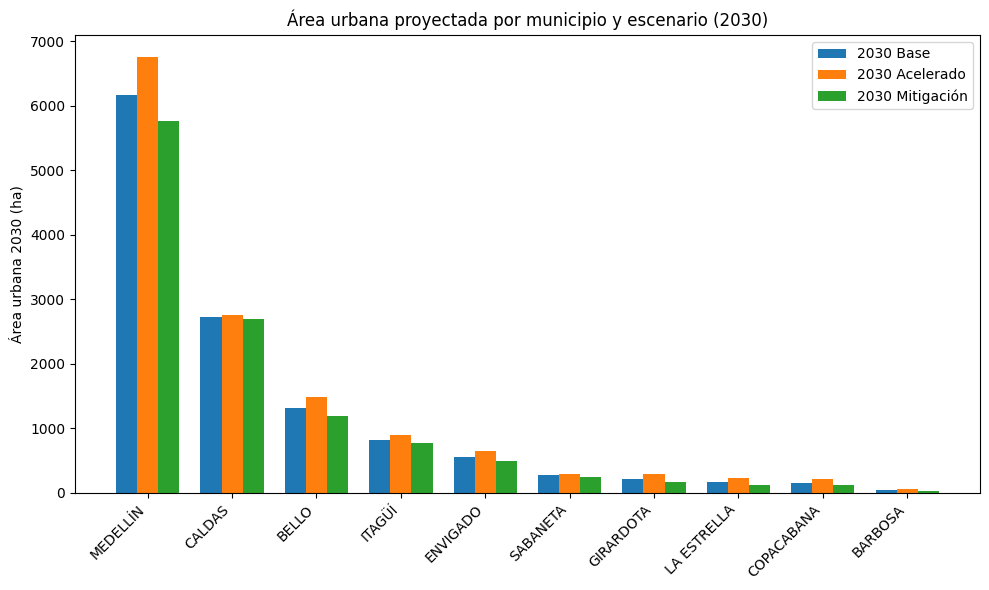

In [ ]:
tabla_plot = tabla_mpios.copy()
tabla_plot = tabla_plot.set_index(nombre_col_mpio)

tabla_plot = tabla_plot.sort_values("A_2030_base_ha", ascending=False)

plt.figure(figsize=(10, 6))
x = np.arange(len(tabla_plot.index))
w = 0.25

plt.bar(x - w, tabla_plot["A_2030_base_ha"],  width=w, label="2030 Base")
plt.bar(x,       tabla_plot["A_2030_acel_ha"], width=w, label="2030 Acelerado")
plt.bar(x + w,   tabla_plot["A_2030_mit_ha"],  width=w, label="2030 Mitigación")

plt.xticks(x, tabla_plot.index, rotation=45, ha="right")
plt.ylabel("Área urbana 2030 (ha)")
plt.title("Área urbana proyectada por municipio y escenario (2030)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
gdf_mpios["A_dif_acel_base_ha"] = area_urbana_por_mpio(diff_acel_path, gdf_mpios, px_ha)
gdf_mpios["A_dif_base_mit_ha"]  = area_urbana_por_mpio(diff_mit_path,  gdf_mpios, px_ha)

tabla_dif = gdf_mpios[[nombre_col_mpio, "A_dif_acel_base_ha", "A_dif_base_mit_ha"]]\
                .sort_values("A_dif_acel_base_ha", ascending=False)
tabla_dif


,MPIO_CNMBR,A_dif_acel_base_ha,A_dif_base_mit_ha
0,MEDELLÍN,445.95,206.28
1,BELLO,121.05,54.27
3,ENVIGADO,81.18,34.29
9,GIRARDOTA,66.78,36.45
7,LA ESTRELLA,58.14,33.39
4,COPACABANA,50.76,26.73
8,ITAGÜÍ,50.31,27.72
5,CALDAS,34.56,25.65
6,SABANETA,26.19,12.87
2,BARBOSA,17.64,9.63


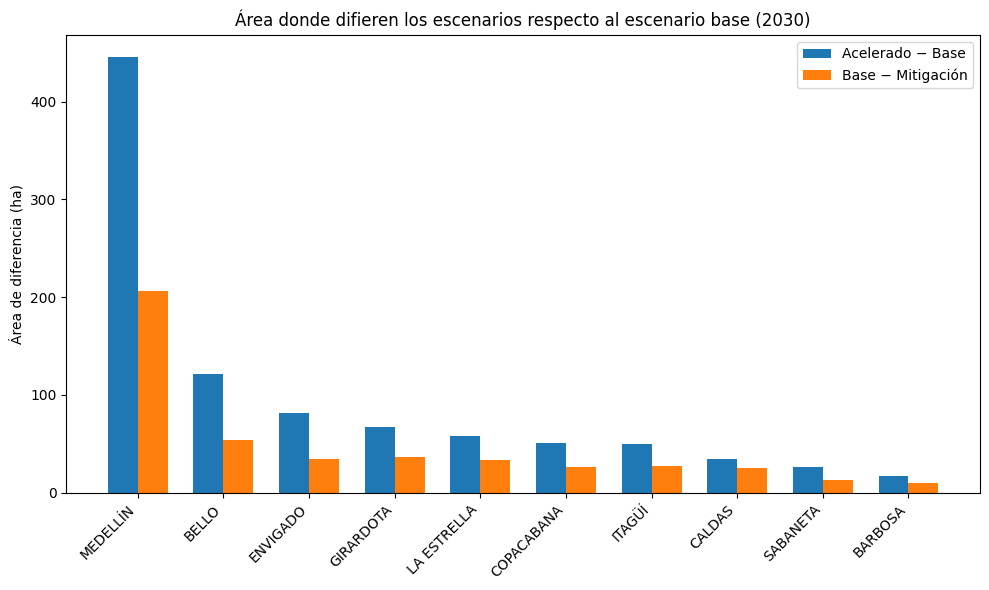

In [ ]:

tabla_plot_dif = gdf_mpios[[nombre_col_mpio, "A_dif_acel_base_ha", "A_dif_base_mit_ha"]].copy()
tabla_plot_dif = tabla_plot_dif.set_index(nombre_col_mpio)
tabla_plot_dif = tabla_plot_dif.sort_values("A_dif_acel_base_ha", ascending=False)

plt.figure(figsize=(10, 6))
x = np.arange(len(tabla_plot_dif.index))
w = 0.35

plt.bar(x - w/2, tabla_plot_dif["A_dif_acel_base_ha"], width=w, label="Acelerado − Base")
plt.bar(x + w/2, tabla_plot_dif["A_dif_base_mit_ha"], width=w, label="Base − Mitigación")

plt.xticks(x, tabla_plot_dif.index, rotation=45, ha="right")
plt.ylabel("Área de diferencia (ha)")
plt.title("Área donde difieren los escenarios respecto al escenario base (2030)")
plt.legend()
plt.tight_layout()
plt.show()
